# Data Generation From Preprocessed CSV

In [58]:
import sys
sys.path.append("../")

import pandas as pd

from imblearn.over_sampling import SMOTE

from Dataset.data_generation_csv import *

## Generate Large Dataset

In [7]:
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)
raw_test_df = pd.read_csv("Data/mitbih_test.csv", header=None)

x_train = raw_train_df.iloc[:, :-1]
y_train = raw_train_df.iloc[:, -1]
x_test  = raw_test_df.iloc[:, :-1]
y_test  = raw_test_df.iloc[:, -1]

smote = SMOTE(sampling_strategy={1: 30000, 2: 20000, 3: 20000, 4: 10000}, random_state=0)
x_train, y_train = smote.fit_resample(x_train, y_train)

training_data = {
    "features": x_train,
    "labels"  : y_train,
}
test_data = {
    "features": x_test,
    "labels"  : y_test,
}

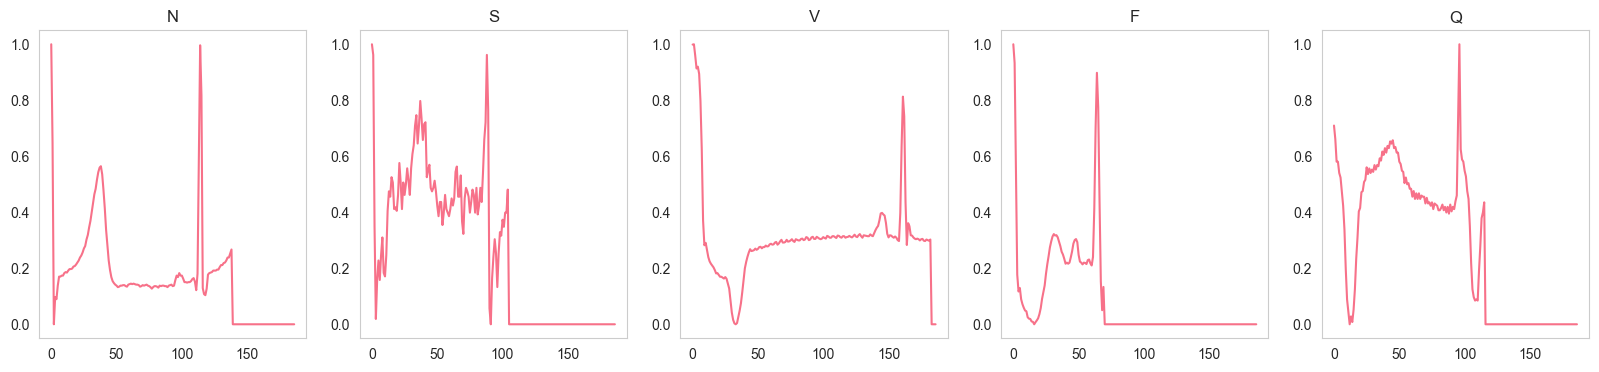

In [24]:
visualize_raw_ecg(training_data)

In [ ]:
transform_data("Data/mitbih_mif_train.h5", training_data, batch_size=5000)
transform_data("Data/mitbih_mif_test.h5", test_data, batch_size=5000)

## Generate Small Training Set

In [18]:
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)

training_data = {
    "features": raw_train_df.iloc[60000:, :-1],
    "labels"  : raw_train_df.iloc[60000:, -1],
}

In [ ]:
transform_data("Data/mitbih_mif_train_small.h5", training_data, batch_size=5000)

## Generate Calibration Datasets For Quantization

In [ ]:
def process_data_frame(df, save_path):
    training_data = {
        "features": df.iloc[:, :-1],
        "labels":   df.iloc[:, -1]
    }
    transform_data(save_path, training_data, batch_size=1000)


def class_distribution(df):
    print(df.value_counts(normalize=True))

n_samples = 3200

# Original dataset
print("Original dataset class distribution")
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)
class_distribution(raw_train_df[187])
print()

# Random sample
random_sample = raw_train_df.sample(n=n_samples, random_state=1)
print("Processing random sample calibration set")
class_distribution(random_sample[187])
process_data_frame(random_sample, "Data/mitbih_calib_random.h5")
print()

# Balanced dataset
labels_df = []
for label in range(5):
    label_filtered_df = raw_train_df[raw_train_df[187] == label]
    labels_df.append(label_filtered_df.sample(n=(n_samples//5), random_state=1))

balanced_sample = pd.concat(labels_df, ignore_index=True)
print("Processing balanced sample calibration set")
class_distribution(balanced_sample[187])
process_data_frame(random_sample, "Data/mitbih_calib_balanced.h5")
print()


# Data Generation From Raw Database

In [1]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_raw_dataset, create_image_dataset

window_size = 128
batch_size  = 5000

data_path  = "Data/MIT-BIH-Raw/mit-bih-arrhythmia-database-1.0.0"
raw_path   = f"Data/MIT-BIH-Raw/signal_unfiltered_i{window_size}.h5"
image_path = f"Data/MIT-BIH-Raw/image_unfiltered_i{window_size}.h5"

create_raw_dataset(data_path, raw_path, window_size)
create_image_dataset(raw_path, image_path, batch_size)

[2024-07-02 16:57:40,313] [DTGEN] [INFO] Processing all records
[2024-07-02 16:57:40,313] [DTGEN] [INFO] 	Processing Record 100
[2024-07-02 16:57:40,354] [DTGEN] [INFO] 		Heartbeats: 2272
[2024-07-02 16:57:40,355] [DTGEN] [INFO] 		Classes: {'normal': 2238, 'sveb': 33, 'veb': 1, 'fusion': 0, 'unknown': 0}
[2024-07-02 16:57:40,853] [DTGEN] [INFO] 	Record 100 added to dataset Data/MIT-BIH-Raw/signal_unfiltered_i128.h5 in 0.5408s
[2024-07-02 16:57:40,854] [DTGEN] [INFO] 	Processing Record 101
[2024-07-02 16:57:41,260] [DTGEN] [INFO] 		Heartbeats: 1865
[2024-07-02 16:57:41,261] [DTGEN] [INFO] 		Classes: {'normal': 1860, 'sveb': 3, 'veb': 0, 'fusion': 0, 'unknown': 2}
[2024-07-02 16:57:41,769] [DTGEN] [INFO] 	Record 101 added to dataset Data/MIT-BIH-Raw/signal_unfiltered_i128.h5 in 0.9145s
[2024-07-02 16:57:41,769] [DTGEN] [INFO] 	Processing Record 103
[2024-07-02 16:57:41,863] [DTGEN] [INFO] 		Heartbeats: 2084
[2024-07-02 16:57:41,865] [DTGEN] [INFO] 		Classes: {'normal': 2082, 'sveb': 2, '